In [1]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

batch_size = 32
img_height = 180
img_width = 180

# Define the data transformations
data_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

# Specify the paths to your train and validation datasets
path_train = "model/Data set/train"
path_validate = "model/Data set/test"

# Create a dataset using torchvision ImageFolder
train_dataset = torchvision.datasets.ImageFolder(
    root=path_train,
    transform=data_transform,
)

validate_dataset = torchvision.datasets.ImageFolder(
    root=path_validate,
    transform=data_transform,
)

# Split the train_dataset into training and validation subsets
train_size = int(0.8 * len(train_dataset))
validate_size = len(train_dataset) - train_size
train_dataset, validate_dataset = random_split(train_dataset, [train_size, validate_size])

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size)

# Get the class names
class_names = train_dataset.dataset.classes
class_name = {i + 1: class_names[i] for i in range(len(class_names))}

print(class_names)
print(class_name)


['healthy_leaf', 'rot', 'rust']
{1: 'healthy_leaf', 2: 'rot', 3: 'rust'}


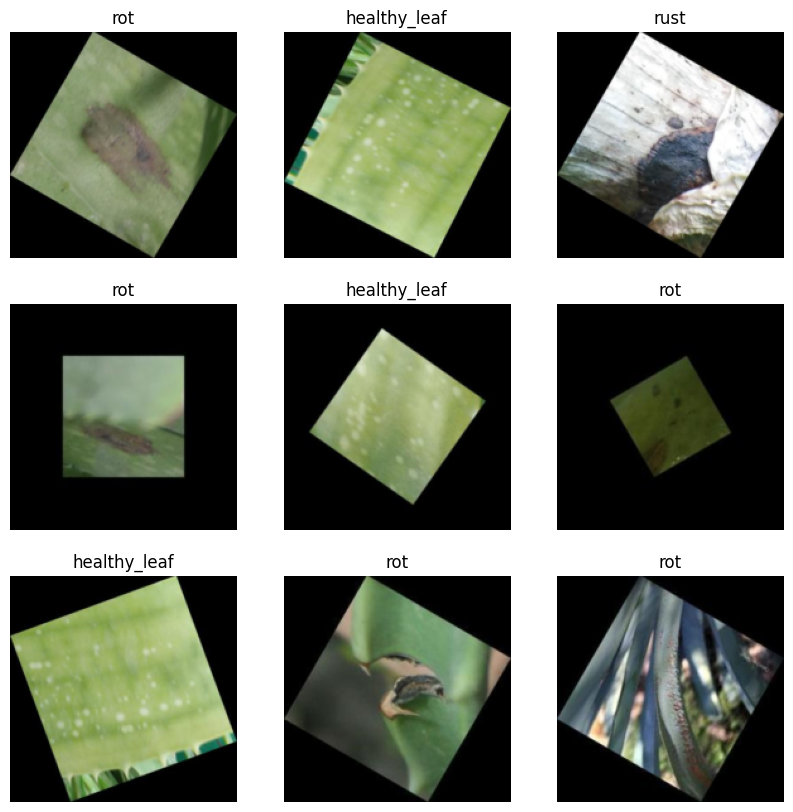

In [2]:
import matplotlib.pyplot as plt

count = 0  # Initialize a count to keep track of how many images have been plotted

plt.figure(figsize=(10, 10))

for images, labels in train_loader:
    for i in range(len(images)):  # Iterate over all available images in the batch
        if count >= 9:
            break  # Exit the loop if you've plotted 9 images
        ax = plt.subplot(3, 3, count + 1)

        # Ensure that the image data is in the correct format (e.g., HWC for PyTorch)
        image = images[i].permute(1, 2, 0).numpy()

        # If your data is not in the range [0, 1], you may need to adjust the scaling
        plt.imshow(image)
        plt.title(class_names[labels[i]])
        plt.axis("off")
        count += 1
    if count >= 9:
        break  # Exit the outer loop if you've plotted 9 images

plt.show()


In [3]:
import torch
import torch.nn as nn

num_classes = len(class_names)

class Net(nn.Module):
    def __init__(self, num_classes, img_height, img_width):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (img_height // 8) * (img_width // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the input shape and number of classes
# img_height, img_width, num_classes = 224, 224, 10  # Adjust the values as needed

# Create the model
model = Net(num_classes, img_height, img_width)

print(f"No of Classes : {num_classes}")

No of Classes : 3


In [4]:
import torch
import torch.optim as optim
import torch.nn as nn

# Define your PyTorch model (assuming you have already defined it)
# model = Net()  # Instantiate your model
model = Net(num_classes, img_height, img_width) # Instantiate your model

# Define the optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters())

# Define the loss function (e.g., Sparse Categorical Cross-Entropy)
criterion = nn.CrossEntropyLoss()

# Optionally, you can also specify any additional metrics you want to track during training.

# Example metric function (accuracy)
def accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    total = target.size(0)
    return correct / total

# This is just an example; you can add more metrics as needed.

# You can then use these objects during your training loop.


In [5]:
def summary(model, input_size):
    print(model)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Trainable Parameters: {total_params}")
    print(f"Input Size: {input_size}")

# Example usage of the summary function
input_size = (3, img_height, img_width)  # Adjust the input size based on your data
summary(model, input_size)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=30976, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)
Total Trainable Parameters: 3989027
Input Size: (3, 180, 180)


In [7]:
import torch
import torch.optim as optim
import torch.nn as nn

# Assuming you've already defined your model, optimizer, loss function, and data loaders

# Specify the number of epochs
epochs = 20

# Define a function for training
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_samples = 0
    correct_predictions = 0

    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            running_loss += loss.item()
            total_samples += labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        # Calculate accuracy and print the average loss for the current epoch
        accuracy = 100.0 * correct_predictions / total_samples
        average_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {average_loss:.4f} - Accuracy: {accuracy:.2f}%")
        running_loss = 0.0
        total_samples = 0
        correct_predictions = 0

# Train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Assuming you have defined train_loader
train_model(model, train_loader, optimizer, criterion, device)


Epoch [1/20] - Loss: 0.0736 - Accuracy: 97.32%
Epoch [2/20] - Loss: 0.0534 - Accuracy: 97.93%
Epoch [3/20] - Loss: 0.0411 - Accuracy: 98.40%
Epoch [4/20] - Loss: 0.0288 - Accuracy: 98.92%
Epoch [5/20] - Loss: 0.0416 - Accuracy: 98.53%
Epoch [6/20] - Loss: 0.0422 - Accuracy: 98.70%
Epoch [7/20] - Loss: 0.0374 - Accuracy: 98.62%
Epoch [8/20] - Loss: 0.0274 - Accuracy: 99.01%
Epoch [9/20] - Loss: 0.0350 - Accuracy: 98.70%
Epoch [10/20] - Loss: 0.0293 - Accuracy: 99.14%
Epoch [11/20] - Loss: 0.0261 - Accuracy: 99.09%
Epoch [12/20] - Loss: 0.0197 - Accuracy: 99.18%
Epoch [13/20] - Loss: 0.0208 - Accuracy: 98.96%
Epoch [14/20] - Loss: 0.0193 - Accuracy: 99.18%
Epoch [15/20] - Loss: 0.0183 - Accuracy: 99.09%
Epoch [16/20] - Loss: 0.0173 - Accuracy: 99.05%
Epoch [17/20] - Loss: 0.0223 - Accuracy: 99.05%
Epoch [18/20] - Loss: 0.0166 - Accuracy: 99.18%
Epoch [19/20] - Loss: 0.0192 - Accuracy: 99.01%
Epoch [20/20] - Loss: 0.0202 - Accuracy: 99.14%


###  Predict New Data


In [8]:
import pandas as pd
import numpy as np


In [10]:
df = pd.read_csv("model/data_description.csv")
df = df.replace('',np.nan)
df = df.dropna(axis="rows",how="all")
df = df.dropna(axis="columns",how="all")
df

,Disease,Description,Symptoms,Diagnosis,Precaution,Medicine for cure,Stage,Severity,Recommended treatment,Remedy to cure
0,Healthy,"Smooth, green leaves with no spots or discolor...",Visual inspection.,"Water regularly, but avoid overwatering. Ferti...",None required.,None required,Good,NaN,Cut off the affected parts of the plant and le...,"Bright, indirect sunlight with well-draining s..."
1,Rot,"Black or brown spots on the leaves, which may ...",Visual inspection.,Remove infected leaves and dispose of them pro...,"Copper fungicides, Chlorothalonil, Propiconazole","Sulfur fungicide, Copper fungicide, Neem oil W...",Late,na,Remove all infected leaves and stems. Apply a ...,"Bright, indirect sunlight with well-draining s..."
2,Rust,"Orange or brown spots on the leaves, which may...",Visual inspection and microscopic examination.,Remove infected leaves and dispose of them pro...,"Mancozeb, Chlorothalonil, Propiconazole, Sulphur","Neem oil, Sulfur powder, Baking soda solution,...",Intermediate,na,Apply a fungicide such as Mancozeb or Chloroth...,"Bright, indirect sunlight with well-draining s..."


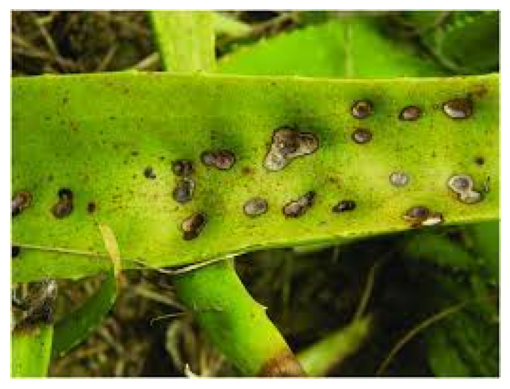

In [17]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

# Path to the image
path = "model/Data set/rot.jpeg"

# Load and display the image using PIL and Matplotlib
img = Image.open(path)

plt.imshow(img)
plt.axis('off')
plt.show()


In [18]:
import torch
from torchvision import transforms
from PIL import Image

# Path to the image
# path = "mango_dataset/test/Healthy/healthy_146.jpg"

# Define transformations and preprocessing
preprocess = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

# Load and preprocess the image, then remove alpha channel if it exists
img = Image.open(path).convert('RGB')
img = preprocess(img)
img = img.unsqueeze(0)  # Add a batch dimension

# Make a prediction with your PyTorch model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    prediction = model(img)

# Get the predicted class
predicted_class = torch.argmax(prediction).item()

Disease	,Description	,Symptoms	,Diagnosis	,Precaution	,Medicine_for_cure	,Stage	,Severity	,Recommended_treatment	,Remedy_to_cure	 = df.loc[predicted_class,:]

print(f"Predicted class: {predicted_class}")
print(f"Predicted disease: {class_names[predicted_class]}")

print(f"Disease : {Disease}\nDescription : {Description}\nSymptoms : {Symptoms}\nDiagnosis : {Diagnosis}\nPrecaution : {Precaution}\nSeverity : {Severity}\nRecommended_treatment : {Recommended_treatment}\nRemedy_to_cure : {Remedy_to_cure}")


Predicted class: 1
Predicted disease: rot
Disease : Rot
Description : Black or brown spots on the leaves, which may spread to the rest of the plant. The leaves may become slimy and soft.
Symptoms : Visual inspection.
Diagnosis : Remove infected leaves and dispose of them properly. Apply a fungicide to the plant.
Precaution : Copper fungicides, Chlorothalonil, Propiconazole
Severity : na
Recommended_treatment : Remove all infected leaves and stems. Apply a fungicide to the plant every 7-10 days until the disease is under control.
Remedy_to_cure : Bright, indirect sunlight with well-draining soil. Avoid overwatering.


In [16]:
torch.save(model.state_dict(),'CNN_model123.pth')